# Exercise 2 - R: Logistic Regression

## *Part One*: Logistic regression without regularization

Beginning with package imports, data loading, and initial visualization

In [1]:
rm(list=ls())  # Clearing all environment variables

suppressPackageStartupMessages({
  library(readr)
  library(ggplot2)
  library(dplyr)
})

theme_update(plot.title = element_text(hjust = 0.5))  # Centers ggplot2 titles

Warning message:
"package 'readr' was built under R version 3.3.3"

In [2]:
df <- read_csv("~/ex2/ex2data1.txt",
                   col_names = FALSE,
                   col_types = 'ddd')

colnames(df) <- c('Exam1Score', 'Exam2Score', 'Admitted')

# Inserting ones for the intercept
df <- cbind(Intercept=1, df)

X <- df %>% select(-Admitted)
y <- df$Admitted

# An array of 0s for starting values of theta to be used in many functions
initialTheta <- c(0,0,0)

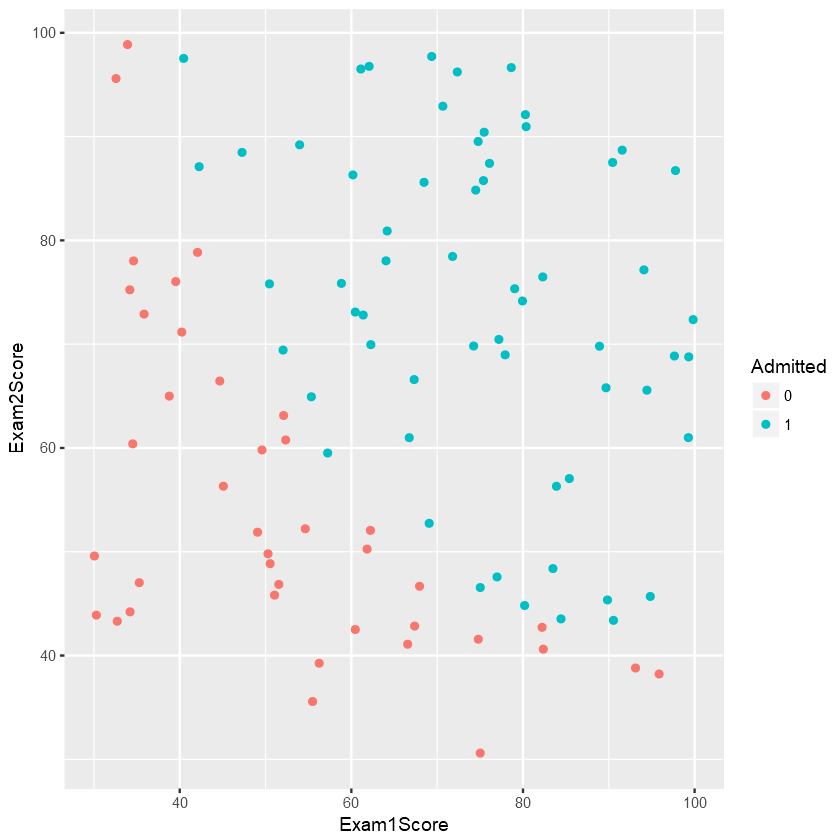

In [3]:
ggplot(df) +
  geom_point(aes(x=Exam1Score, y=Exam2Score, color=as.factor(Admitted))) + 
  labs(color='Admitted') 

### Sigmoid Function

$g(z) = \frac{1}{1+e^{-z}}$

Converts $z$ into a value between 0 and 1

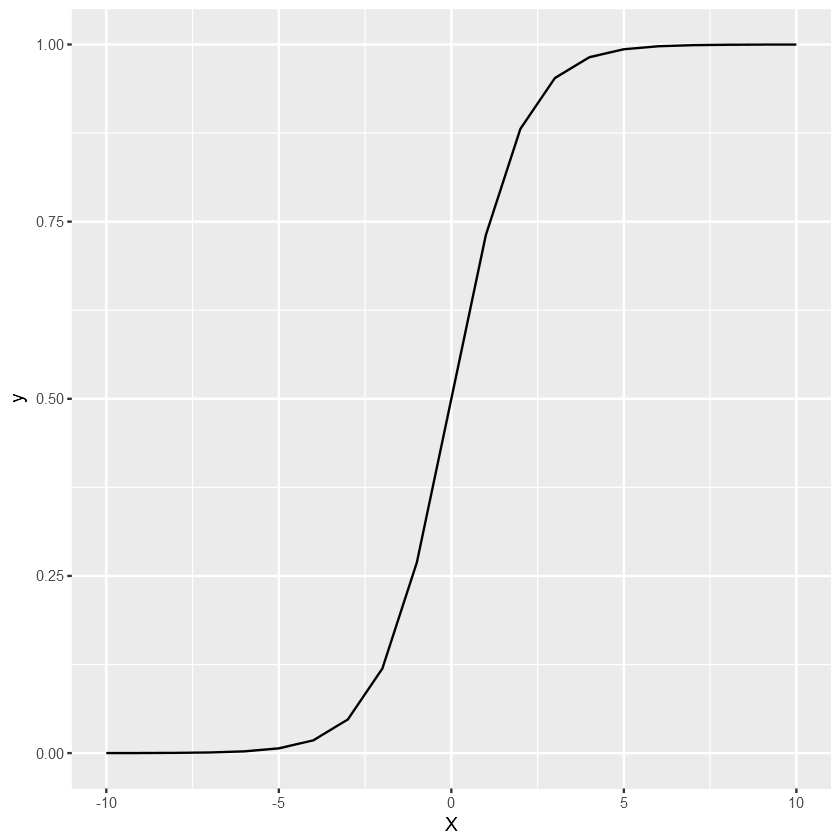

In [4]:
sigmoid <- function(z){
  # Converts numerical input into a value between 0 and 1 
  return(1/(1+exp(-z))) 
}

# Plotting to validate that the function is working
data.frame(X = -10:10) %>% 
  mutate(y = sigmoid(X)) %>% 
  ggplot() + 
    geom_line(aes(x=X, y=y))

### Logistic Regression Hypothesis

$h_\theta(x) = g(\theta^Tx)$

- Notation:

    - $g$: Sigmoid function

    - $\theta^T$: Transposed parameters
       
        - E.x.: $\theta^T = \begin{bmatrix} \theta_1 \\ \theta_2 \\ \vdots \\ \theta_n \end{bmatrix}$

In [5]:
logistic_hypothesis <- function(theta, X){
  # Calculates the hypothesis for X given values of
  # theta for logistic regression
  X <- as.matrix(X)
  theta <- as.matrix(theta)
  h <- X %*% theta
  return(sigmoid(h))
}

logistic_hypothesis(initialTheta, head(X))

1,0.5
2,0.5
3,0.5
4,0.5
5,0.5
6,0.5


### Cost Function

$J(\theta) = \frac{1}{m} \sum_{i=1}^m[-y^{(i)}log(h_\theta(x^{(i)})) - (1-y^{(i)})log(1-h_\theta(x^{(i)}))]$

- Notation:

    - $m$: Number of records

    - $h_\theta$: Logistic hypothesis $(h)$ given specific values of $\theta$ for parameters
    
    - $i$: Index of the record (e.x. if $i = 46$, then 46th row)

In [6]:
cost_function <- function(theta, X, y){
  # Computes cost for logistic regression
  m <- length(y)
  h <- logistic_hypothesis(theta, X)
  error <- sum(-y*log(h)-(1-y)*log(1-h))
  J <- (1/m)*error
  return(J)
}

cost_function(initialTheta, X, y)

[1] 0.6931472

### Gradient

$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}$

- Notation:

    - $\partial$: Partial derivative
    
    - $J(\theta)$: Cost given $\theta$

    - $m$: Number of records
    
    - $h_\theta$: Logistic hypothesis $(h)$ given specific values of $\theta$ for parameters
    
    - $i$: Index of the record (e.x. if $i = 46$, then 46th row)

In [7]:
gradient <- function(theta, X, y){
  # Computes the gradient for logistic regression
  X <- as.matrix(X)
  y <- as.matrix(y)
  theta <- as.matrix(theta)
  
  m <- length(y)
  h <- logistic_hypothesis(theta, X)
  gradient <- (1/m) * (t(X) %*% (h-y))
  return(gradient)
}

gradient(initialTheta, X, y)

Intercept,-0.10000
Exam1Score,-12.00922
Exam2Score,-11.26284


Finding the optimal values of $\theta_j$ for the cost function using the base R optim function.  This is similar to MATLAB's fminunc function.

In [8]:
# Find values of theta that minimize the cost function
optimalTheta <- optim(
      # Specifying function parameters
      par=initialTheta,  # Initial guess
      fn=cost_function,  # Function to minimize
      X=X,
      y=y,
      method="BFGS",  #  Optimization function to use
      control = list(maxit = 400)  # Maximum number of iterations
     )$par  # Specifying that we only want the obtained thetas

# Pretty printing the obtained values for theta
cat('Cost:', x = cost_function(optimalTheta, X, y), '\n')
cat('\nOptimal Thetas\n',
    'Intercept:', optimalTheta[1], '\n',
    'Theta 1:', optimalTheta[2], '\n',
    'Theta 2:', optimalTheta[3])

Cost: 0.2034978 

Optimal Thetas
 Intercept: -25.18575 
 Theta 1: 0.2064298 
 Theta 2: 0.2016679

Comparing the obtained parameters to what base R's glm function provides

In [9]:
glm(Admitted ~ Exam1Score+Exam2Score, data=df, family=binomial)


Call:  glm(formula = Admitted ~ Exam1Score + Exam2Score, family = binomial, 
    data = df)

Coefficients:
(Intercept)   Exam1Score   Exam2Score  
   -25.1613       0.2062       0.2015  

Degrees of Freedom: 99 Total (i.e. Null);  97 Residual
Null Deviance:	    134.6 
Residual Deviance: 40.7 	AIC: 46.7

Not bad!

Calculating the class probability and generating predictions of acceptance using values of $\theta_j$ obtained from the optimization function

The outputs from logistic regression are just the class probability, or $P(y = 1 \mid x; \theta)$, so we are predicting the classes (accepted or not) as follows:

$Prediction(y \mid x; \theta) = \begin{cases} 1, \quad\mbox{ if } P(y = 1 \mid x; \theta) > 0.50 \\ 0, \quad\mbox{ if } P(y = 1 \mid x; \theta) \leq 0.50 \end{cases} $

In [10]:
# Predicting the class probability with the obtained thetas
df$ClassProbability <- logistic_hypothesis(optimalTheta, X)

# Assigning those with a class probability above 0.5 as admitted
df$Prediction <- ifelse(df$ClassProbability > 0.5, 1, 0)

head(df)

Intercept,Exam1Score,Exam2Score,Admitted,ClassProbability,Prediction
1,34.62366,78.02469,0,9.084887e-02,0
1,30.28671,43.89500,0,4.184675e-05,0
1,35.84741,72.90220,0,4.378303e-02,0
1,60.18260,86.30855,1,9.904669e-01,1
1,79.03274,75.34438,1,9.982096e-01,1
1,45.08328,56.31637,0,1.075034e-02,0


Plotting the decision boundary over the data

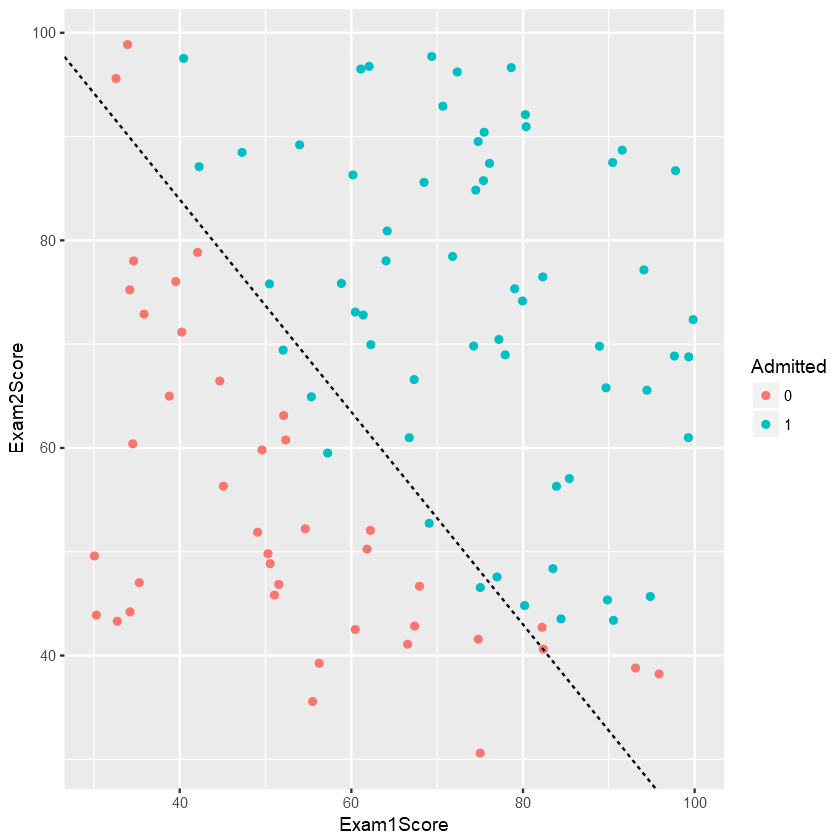

In [11]:
# Calculating and plotting the decision boundary
decisionSlope <- optimalTheta[2]/(-optimalTheta[3])
decisionIntercept <- optimalTheta[1]/(-optimalTheta[3]) 

ggplot(df) +
  geom_point(aes(x=Exam1Score, y=Exam2Score, color=as.factor(Admitted))) + 
  labs(color='Admitted') +
  geom_abline(intercept=decisionIntercept, slope=decisionSlope,
              linetype='dashed')

---

##  **Part 2:** Logistic regression with regularization

Predicting acceptance of microchips based off of two tests

In [12]:
df <- read_csv("~/ex2/ex2data2.txt",
                   col_names = FALSE,
                   col_types = 'ddd')

colnames(df) <- c('Test1', 'Test2', 'Accepted')

y <- df$Accepted

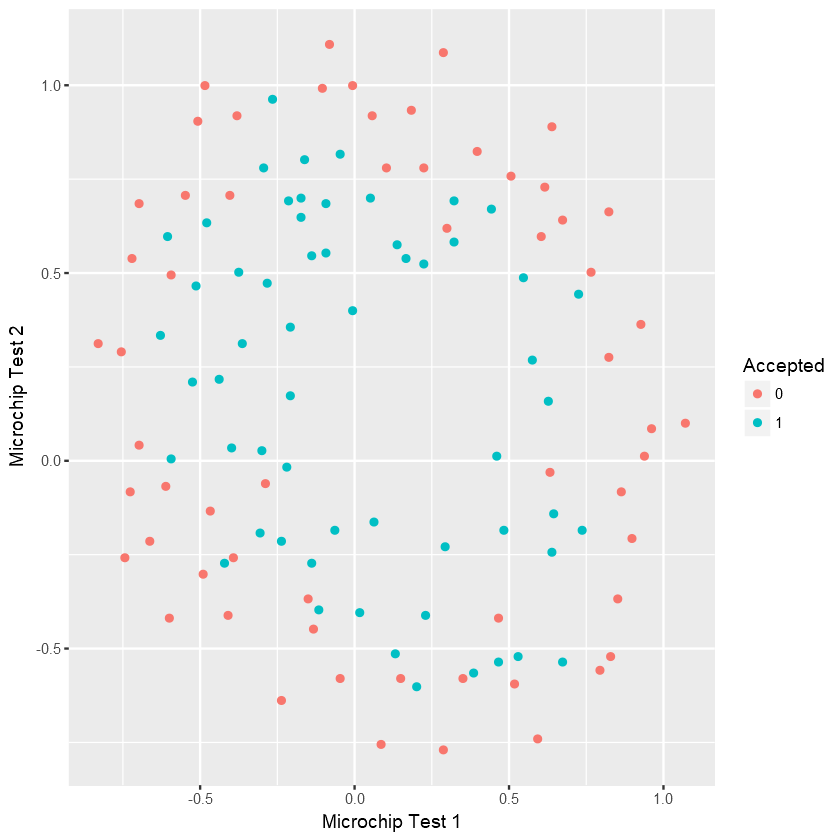

In [13]:
ggplot(df) +
  geom_point(aes(x=Test1, y=Test2, color=as.factor(Accepted))) + 
  labs(color='Accepted') +
  xlab('Microchip Test 1') + 
  ylab('Microchip Test 2')

### Feature Mapping

Maps the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.  This allows for a more complex and nonlinear decision boundary.  

The feature space prior to feature mapping (3-dimensional vector): 

$\hspace{1cm} Feature(x) = \begin{bmatrix} 1 \\ x_1 \\ x_2 \end{bmatrix}$ 

The feature space after feature mapping:

$\hspace{1cm} mapFeature(x) = \begin{bmatrix} 1 \\ x_1 \\ x_2 \\ x_1^2 \\ x_1x_2 \\ x_2^2 \\ x_1^3 \\ \vdots \\ x_1x_2^5 \\ x_2^6 \end{bmatrix}$

**Note:** The Octave/MATLAB code provided for this assignment resulted in a 28-dimensional feature space, but our code will result in a 49-dimensional feature space.  This is because the Octave/MATLAB code provided *some* interaction terms (e.x. $x_1x_2,\ x_1^3x_2^4$, etc.), but not all possible interaction terms.  For simplicity, we'll use all interaction terms.

Octave/MATLAB code:
```
degree = 6;
out = ones(size(X1(:,1)));
for i = 1:degree
    for j = 0:i
        out(:, end+1) = (X1.^(i-j)).*(X2.^j);
    end
end
```

Corresponding R code:
```
X <- matrix(1,length(df$Test1),1)
  
for (i in 1:degree)
  for (j in 0:i)
    out <- cbind(out, (df$Test1 ^ (i - j)) * (df$Test2 ^ j))

```

In [14]:
degree <- 6

# Generating polynomials for Test #1
test1 <- poly(df$Test1, degree, raw=TRUE) %>% data.frame()
colnames(test1) <- c('x1', 'x1_2', 'x1_3', 'x1_4', 'x1_5', 'x1_6')

# Generating polynomials for Test #2
test2 <- poly(df$Test2, degree, raw=TRUE) %>% data.frame()
colnames(test2) <- c('x2', 'x2_2', 'x2_3', 'x2_4', 'x2_5', 'x2_6')

# Creating the interaction terms
X <- cbind(test1, test2)
for (firstTerm in 1:degree) {
  for (secondTerm in 1:degree) {
    if (firstTerm != secondTerm)
      X[, ncol(X) + 1] <- test1[, firstTerm] * test2[, secondTerm]
      names(X)[ncol(X)] <- paste0('x1_', firstTerm, ':', 'x2_', secondTerm)
  }
}

# Inserting ones for the intercept
X <- cbind(x0=1, X)

# Removing test1 and test2 from the environment
rm(test1, test2)

# Creating a new list of initial thetas
initialTheta <- numeric(length(X))

head(X)

x0,x1,x1_2,x1_3,x1_4,x1_5,x1_6,x2,x2_2,x2_3,...,x1_5:x2_1,x1_5:x2_2,x1_5:x2_3,x1_5:x2_5,x1_5:x2_6,x1_6:x2_1,x1_6:x2_2,x1_6:x2_3,x1_6:x2_4,x1_6:x2_6
1,0.051267,0.002628305,0.0001347453,6.907989e-06,3.541519e-07,1.815630e-08,0.69956,0.48938419,0.342353606,...,2.477505e-07,1.733163e-07,1.212452e-07,8.481827e-08,4.150872e-08,1.270142e-08,8.885408e-09,6.215876e-09,4.348378e-09,3.041951e-09
1,-0.092742,0.008601079,-0.0007976812,7.397855e-05,-6.860919e-06,6.362953e-07,0.68494,0.46914280,0.321334672,...,-4.699318e-06,-3.218751e-06,-2.204651e-06,-1.510054e-06,-7.084308e-07,4.358241e-07,2.985134e-07,2.044638e-07,1.400454e-07,9.592270e-08
1,-0.213710,0.045671964,-0.0097605554,2.085928e-03,-4.457837e-04,9.526844e-05,0.69225,0.47921006,0.331733166,...,-3.085938e-04,-2.136241e-04,-1.478813e-04,-1.023708e-04,-4.905712e-05,6.594958e-05,4.565360e-05,3.160370e-05,2.187766e-05,1.514481e-05
1,-0.375000,0.140625000,-0.0527343750,1.977539e-02,-7.415771e-03,2.780914e-03,0.50219,0.25219480,0.126649705,...,-3.724126e-03,-1.870219e-03,-9.392053e-04,-4.716595e-04,-1.189501e-04,1.396547e-03,7.013321e-04,3.522020e-04,1.768723e-04,8.882351e-05
1,-0.513250,0.263425562,-0.1352031700,6.939303e-02,-3.561597e-02,1.827990e-02,0.46564,0.21682061,0.100960349,...,-1.658422e-02,-7.722277e-03,-3.595801e-03,-1.674349e-03,-3.630333e-04,8.511851e-03,3.963458e-03,1.845545e-03,8.593595e-04,4.001521e-04
1,-0.524770,0.275383553,-0.1445130271,7.583610e-02,-3.979651e-02,2.088401e-02,0.20980,0.04401604,0.009234565,...,-8.349308e-03,-1.751685e-03,-3.675035e-04,-7.710223e-05,-3.393735e-06,4.381466e-03,9.192316e-04,1.928548e-04,4.046094e-05,8.488704e-06


### Regularized Cost Function

$J(\theta) = \frac{1}{m} \sum_{i=1}^m[-y^{(i)}log(h_\theta(x^{(i)})) - (1-y^{(i)})log(1-h_\theta(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2$

The only change from the other cost function we used earlier is the addition of the regularization parameter:

#### Regularization Parameter

$\frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2$

- Notation:

    - $\lambda$: The weight which the parameters are adjusted by.  A lower $\lambda$ has little effect on the parameters, and a higher $\lambda$ (e.x. $\lambda = 1,000$) will adjust the parameters to be close to 0.
    - $m$: Number of records
    - $j$: The index for the parameter.  E.x. $\theta_{j=1}$ is the score for Microchip Test #1

**Note:** $\theta_0$ should not be regularized as denoted by the summation in the regularization parameter

In [15]:
regularized_cost <- function(theta, X, y, C){
  # Computes cost for logistic regression
  m <- length(y)
  h <- logistic_hypothesis(theta, X)
  error <- sum(-y*log(h)-(1-y)*log(1-h))
  
  # Calculating the regularization parameter
  # Avoiding the regularization parameter for the first theta
  regularizedTheta <- theta[-1] ** 2
  regularization <- (C/2*m) + sum(regularizedTheta)
  
  J <- (1/m)*error + regularization
  return(J)
}

# Testing how cost differs with regularization
# Using thetas above 0 so the regularization parameter has an impact
regTestTheta <- rep(0.5, length(X))
cat('Cost at lambda=0:', regularized_cost(regTestTheta, X, y, C=0), '\n')
cat('Cost at lambda=1:', regularized_cost(regTestTheta, X, y, C=1), '\n')
cat('Cost at lambda=100:', regularized_cost(regTestTheta, X, y, C=100))

Cost at lambda=0: 11.74226 
Cost at lambda=1: 70.74226 
Cost at lambda=100: 5911.742

### Regularized Gradient

$\frac{\partial J(\theta)}{\partial \theta_j} = \Big(\frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}\Big) + \frac{\lambda}{m}\theta_j \hspace{0.5cm}$for $j \geq 1$

This is also the same as the last gradient with the exception of the regularization parameter

#### Regularization Parameter

$\frac{\lambda}{m}\theta_j \hspace{0.5cm}$for $j \geq 1$

- Notation:

    - $\lambda$: The weight which the parameters are adjusted by.  A lower $\lambda$ has little effect on the parameters, and a higher $\lambda$ (e.x. $\lambda = 1,000$) will adjust the parameters to be close to 0.
    - $m$: Number of records
    - $j$: The index for the parameter.  E.x. $\theta_{j=1}$ is the score for Microchip Test #1

In [16]:
regularized_gradient <- function(theta, X, y, C){
  # Computes the gradient for logistic regression
  
  # Removing the intercept term
  X <- as.matrix(X)[, -1]
  theta <- as.matrix(theta)[-1]
  
  y <- as.matrix(y)
  m <- length(y)
  h <- logistic_hypothesis(theta, X)
  
  gradient <- (1/m) * (t(X) %*% (h-y))
  return(gradient)
}

t(regularized_gradient(initialTheta, X, y, C=1.0))

x1,x1_2,x1_3,x1_4,x1_5,x1_6,x2,x2_2,x2_3,x2_4,...,x1_5:x2_1,x1_5:x2_2,x1_5:x2_3,x1_5:x2_5,x1_5:x2_6,x1_6:x2_1,x1_6:x2_2,x1_6:x2_3,x1_6:x2_4,x1_6:x2_6
0.01878809,0.05034464,0.01835599,0.03934862,0.01997075,0.03103124,7.777119e-05,0.03766485,0.02347649,0.03930282,...,0.001097402,0.002325008,0.0002364315,0.0008285108,0.0003405805,0.002742397,0.0035645,0.0009573749,0.00125746,0.0005556628


Finding the optimal values of $\theta$.  This chunk is surprisingly much quicker than the similar function I used in Python.

In [41]:
# Find values of theta that minimize the cost function
optimalTheta <- optim(
      # Specifying function parameters
      par=initialTheta,  # Initial guess
      fn=regularized_cost,  # Function to minimize
      X=X,
      y=y,
      C=1.0,
      method="BFGS",  #  Optimization function to use
      control = list(maxit = 400)  # Maximum number of iterations
     )$par  # Specifying that we only want the obtained thetas

Checking against R's glm logistic regression.  This is an unregularized approach, but since we used a blanket value of lambda, there shouldn't be a huge difference.

In [38]:
# Fitting the model
model <- glm(y ~ ., data=cbind(X[, -1], y), family='binomial')
modelCoef <- model$coefficients %>% data.frame(glm=.)

cbind(modelCoef, optimalTheta) %>% t()

Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

,(Intercept),x1,x1_2,x1_3,x1_4,x1_5,x1_6,x2,x2_2,x2_3,...,`x1_5:x2_1`,`x1_5:x2_2`,`x1_5:x2_3`,`x1_5:x2_5`,`x1_5:x2_6`,`x1_6:x2_1`,`x1_6:x2_2`,`x1_6:x2_3`,`x1_6:x2_4`,`x1_6:x2_6`
glm,1.786388e+15,7.475402e+15,-1.03106e+16,-4.346014e+16,4.195472e+16,5.929073e+16,-6.100888e+16,5.731703e+14,1.335024e+12,6.085364e+15,...,-1.145441e+17,-3.546498e+17,1.081306e+17,1.152298e+18,-1.358441e+18,3.711537e+17,-7.008500e+16,-7.755682e+17,-7.394062e+16,4.568947e+17
optimalTheta,-6.232157e-03,-8.798644e-03,-2.35968e-02,-8.599117e-03,-1.845654e-02,-9.362569e-03,-1.455706e-02,-2.402402e-04,-1.777094e-02,-1.116613e-02,...,-5.206297e-04,-1.091452e-03,-1.128354e-04,-3.892106e-04,-1.600292e-04,-1.293688e-03,-1.674975e-03,-4.520962e-04,-5.915824e-04,-2.622341e-04


R's glm produced much more extreme values than our implementation.  We'll see how this affects the performance.

Lastly, comparing the accuracy between the two models.  Classification accuracy is just the percentage of records correctly classified (precision, recall, f-1 score, etc. offer more nuanced information on performance), so we will have to calculate the class probabilities and assign predictions like we did for part one:

In [39]:
# Predicting the class probability with the obtained thetas
df$ClassProbability <- logistic_hypothesis(optimalTheta, X)
df$glmClassProbability <- predict(model, X)

# Assigning those with a class probability above 0.5 as admitted
df$Prediction <- ifelse(df$ClassProbability > 0.5, 1, 0)
df$glmPrediction <- ifelse(df$glmClassProbability > 0.5, 1, 0)

head(df)

Test1,Test2,Accepted,ClassProbability,Prediction,glmClassProbability,glmPrediction
0.051267,0.69956,1,0.4928351,0,7.336372e+14,1
-0.092742,0.68494,1,0.4935854,0,1.381208e+15,1
-0.213710,0.69225,1,0.4935158,0,1.141851e+15,1
-0.375000,0.50219,1,0.4965195,0,1.458585e+15,1
-0.513250,0.46564,1,0.4963870,0,3.174210e+14,1
-0.524770,0.20980,1,0.4976765,0,1.087490e+15,1


In [40]:
ourAccuracy <- mean(ifelse(df$Accepted == df$Prediction, 1, 0))
glmAccuracy <- mean(ifelse(df$Accepted == df$glmPrediction, 1, 0))

cat('Our accuracy:', ourAccuracy, '\n')
cat('R\'s glm accuracy:', glmAccuracy)

Our accuracy: 0.5084746 
R's glm accuracy: 0.8389831

Our model has a much lower accuracy, which makes sense when you see how our predictions in the first few records.  Let's look at the distributions of class probabilities between the two:

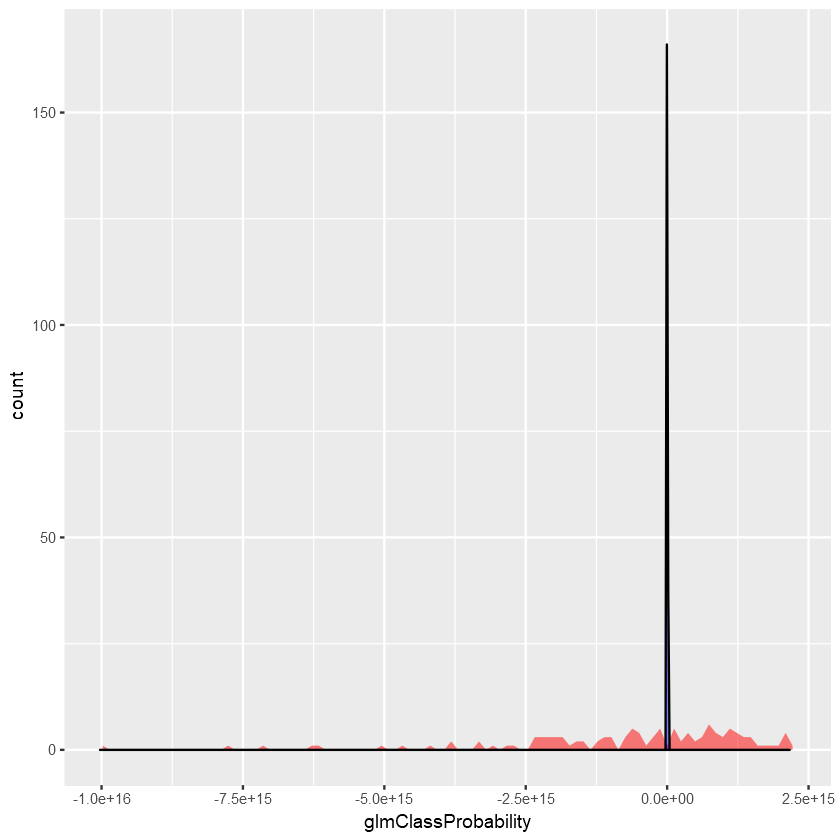

In [46]:
ggplot(df) +
  geom_area(aes(glmClassProbability), stat="bin", fill='red', alpha=0.5, bins=100) +
  geom_density(aes(ClassProbability), fill='blue', alpha=0.5) 

Our class probabilities are very concentrated, but glm's are very extreme.

Let's examine ours in more detail:

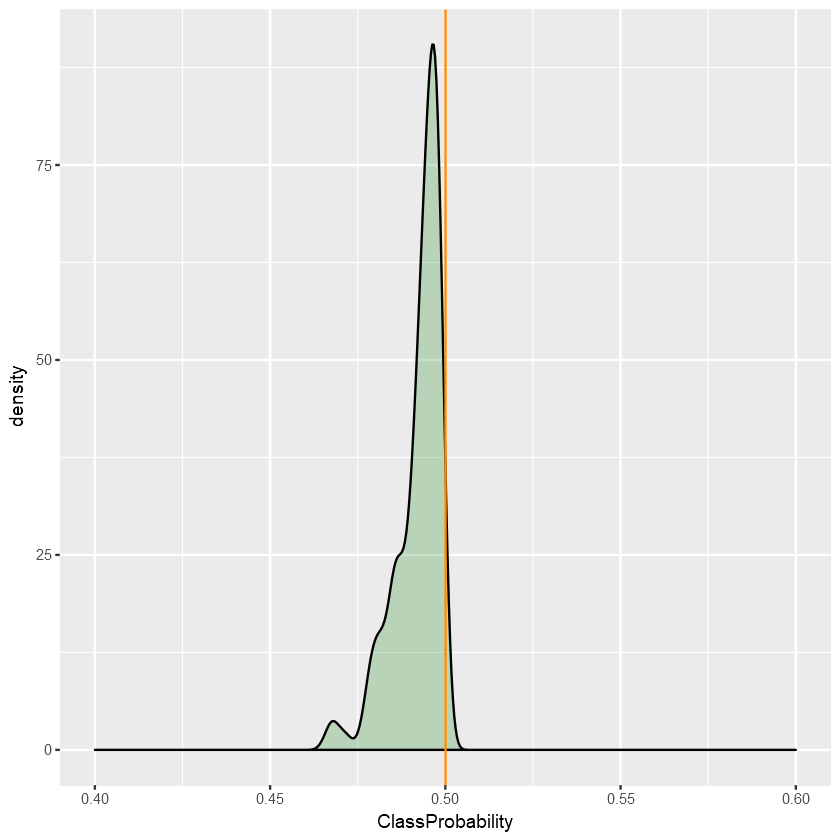

In [69]:
ggplot(df) +
  geom_density(aes(ClassProbability), fill='forestgreen', alpha=0.25) +
  scale_x_continuous(limits=c(0.4, 0.6)) +
  geom_vline(xintercept=0.5, color='darkorange')

Most predictions seem to be very close to the cutoff, but just under them.  One potential way to improve the accuracy further without changing our thetas is to search for a different cutoff value for our predictions.